In [1]:
import numpy as np      
import os# 開啟檔案

import torch
from torch import nn
from torch.utils import data
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchnet import meter

import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from linformer import Linformer


from IPython.display import clear_output

In [2]:
#source https://github.com/lucidrains/vit-pytorch
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class ViT(nn.Module):
    def __init__(self, *, image_size=32, patch_size=4, dim, channels = 3):
        super().__init__()
        image_size_h, image_size_w = pair(image_size)
        assert image_size_h % patch_size == 0 and image_size_w % patch_size == 0, 'image dimensions must be divisible by the patch size'
        
        num_patches = (image_size_h // patch_size) * (image_size_w // patch_size)
        patch_dim = channels * patch_size ** 2
        num_seq = image_size // patch_size
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )
        self.embedding2img = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim,patch_dim ),
            nn.Sigmoid(),
            Rearrange('b (h w) (p1 p2 c)  -> b c (h p1) (w p2)',c = channels, w=num_seq, p2 = patch_size),
           
        )
        
        
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches , dim))
        
        self.transformer = Linformer(   dim=dim,
                                        seq_len=num_seq**2,  # 7x7 patches + 1 cls-token
                                        depth=12,
                                        heads=8,
                                        reversible = True )


    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        x += self.pos_embedding[:, :n ]
        x = self.transformer(x)
    
        return self.embedding2img(x)


model = ViT(
    image_size=28,
    dim=256,
    channels=1
)

In [3]:
#mnist
transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transform)


split=0.8
train_size=int(len(train_set)*split)
traindata, valdata = data.random_split(train_set, [train_size, len(train_set)-train_size])

train_loader = data.DataLoader(traindata, batch_size=64, shuffle=True,num_workers=2)
valid_Loader = data.DataLoader(valdata, batch_size=64, shuffle=True,num_workers=2)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=True,num_workers=2)

In [ ]:
#cifar10
transform = transforms.Compose([transforms.ToTensor()])
train = torchvision.datasets.CIFAR10(root='./', train=True, download=False, transform=transform) # 5000 2d cat
train_loader = data.DataLoader(train, batch_size=64, shuffle=True)

test = torchvision.datasets.CIFAR10(root='./', train=False, download=False, transform=transform)
test_loader = data.DataLoader(test, batch_size=64, shuffle=True)

In [4]:
# Parameters
device ='cuda:0' if torch.cuda.is_available() else 'cpu'
print(device,'is available!\n')
model= model.to(device)
#print(model)

criterion  = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler=lr_scheduler.CosineAnnealingLR(optimizer,5)

cuda:0 is available!



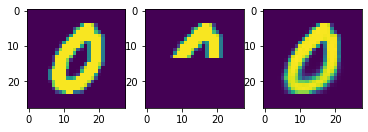

Early stopping!
Finished Training!


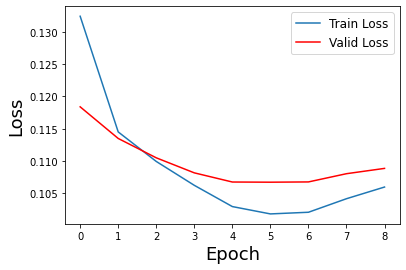

In [5]:
epochs=20
loss_meter = meter.AverageValueMeter()
loss_dic={'train_loss':[], 'valid_loss':[], 'lr':[]}

#early_stopping
patience=3
earlystop=0
best_loss=float('inf')


for epoch in range(epochs):
    #train
    model.train()
    loss_meter.reset()
    with tqdm(train_loader) as tepoch:
        
        for inputs, labels in tepoch:
            tepoch.set_description(f'TrainEpoch{epoch+1:3d}')
            
            _,_,h,w=inputs.size()
            msk= torch.ones(inputs.size())
            msk[:,:,h//2:,:]=0
            inputs,target=inputs*msk, inputs

            #inputs,target=inputs, inputs
            inputs,target=inputs.to(device), target.to(device)

            # Forward
            out = model(inputs)

            # Backward
            optimizer.zero_grad()
            crit = criterion(out, target)
            loss_meter.add(crit.item())
            crit.backward()
            optimizer.step()
            tepoch.set_postfix({'loss':'{0:.3f}'.format(loss_meter.value()[0])})
    
    
    loss_dic['train_loss'].append(loss_meter.value()[0])
    scheduler.step()
    #valid
    model.eval()
    loss_meter.reset()
    with tqdm(valid_Loader) as tepoch:
        
        for inputs, labels in tepoch:
            tepoch.set_description(f'ValidEpoch{epoch+1:3d}')
            
            _,_,h,w=inputs.size()
            msk= torch.ones(inputs.size())
            msk[:,:,h//2:,:]=0
            inputs,target=inputs*msk, inputs

            #inputs,target=inputs, inputs
            inputs,target=inputs.to(device), target.to(device)

            # Forward
            out = model(inputs)
            
            crit = criterion(out, target)
            loss_meter.add(crit.item())
               
            tepoch.set_postfix({'loss':'{0:.3f}'.format(loss_meter.value()[0])})
    
    loss_dic['valid_loss'].append(loss_meter.value()[0])
    loss_dic['lr'].append(scheduler.get_last_lr())
    clear_output(wait=True)
    
    # Show progress
    f, ax = plt.subplots(1,3) 
    ax[0].imshow(torchvision.transforms.ToPILImage()(target[0])) 
    ax[1].imshow(torchvision.transforms.ToPILImage()(inputs[0])) 
    ax[2].imshow(torchvision.transforms.ToPILImage()(out[0])) 
    plt.show()
    
    # earlystopping
    cur_loss=loss_meter.value()[0]
    if cur_loss>best_loss:
        earlystop+=1
        if earlystop>= patience:
            print('Early stopping!')
            break
    else:
        earlystop=0
        best_loss=cur_loss

print('Finished Training!')

#plot training loss and valid loss


plt.plot(loss_dic['train_loss'])
plt.plot(loss_dic['valid_loss'],color='r')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(["Train Loss", "Valid Loss"],fontsize=12)
plt.show()


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 16.56it/s]


----------------------------------------------------PREDICT----------------------------------------------------


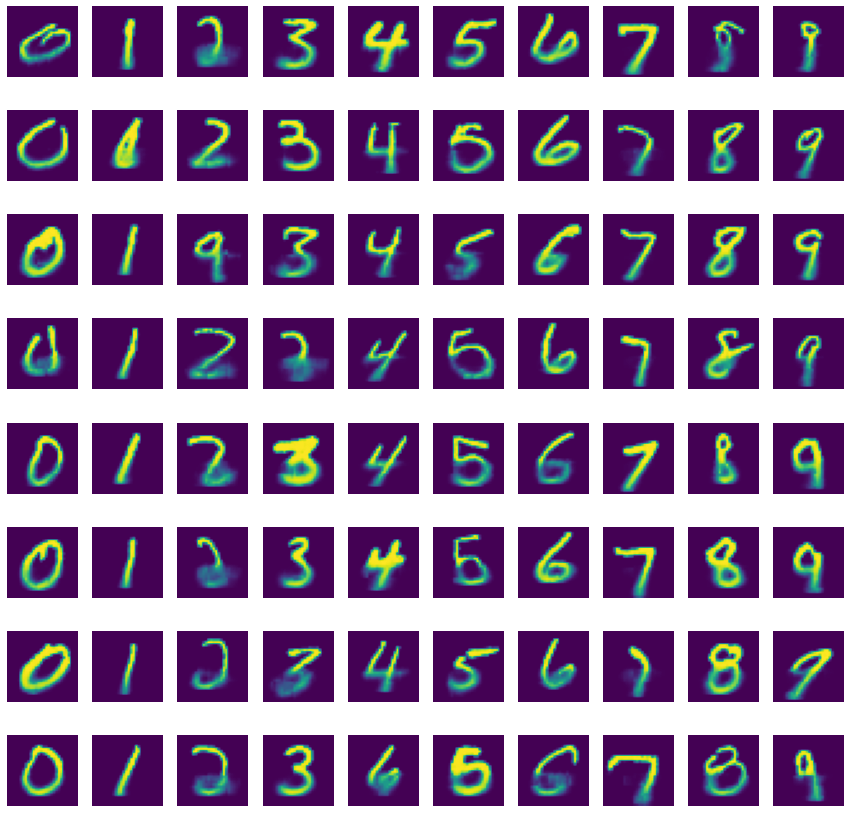

----------------------------------------------------TARGET----------------------------------------------------


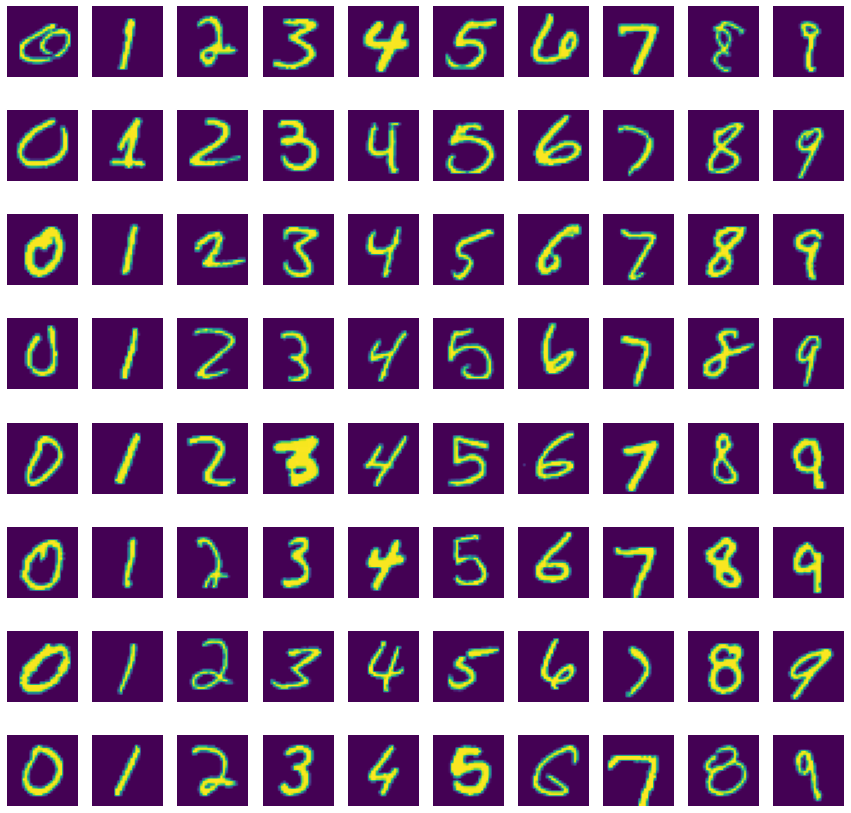

In [6]:
img_set={}
target_set={}
model.eval()
with tqdm(test_loader) as tepoch:
    for img ,label in tepoch:
        _,_,h,w=img.size()
        msk= torch.ones(img.size())
        msk[:,:,h//2:,:]=0 #cover half img

        inputs,target=img*msk, img
        inputs,target=inputs.to(device), target.to(device)
        out = model(inputs)
        
        for idx in range(len(label)):
            
            l=int(label[idx].cpu().detach().numpy())
            i=out[idx].cpu()
            t=target[idx].cpu()
            
            if l not in img_set:
                img_set[l]=[i]
                target_set[l]=[t]
            else:
                img_set[l].append(i)
                target_set[l].append(t)

print('-'*52+'PREDICT'+'-'*52)
f, ax = plt.subplots(8,10,figsize=(15,15))
for i in range(10):
    for j in range(8):
        ax[j][i].imshow(torchvision.transforms.ToPILImage()(img_set[i][j]))
        ax[j][i].axis('off')
plt.show()
print('-'*52+'TARGET'+'-'*52)
f, ax = plt.subplots(8,10,figsize=(15,15))
for i in range(10):
    for j in range(8):
        ax[j][i].imshow(torchvision.transforms.ToPILImage()(target_set[i][j]))
        ax[j][i].axis('off')
plt.show()